In [2]:
# Emagram  Hodograph  
#   R. Kurora
from datetime import datetime
#
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#
import pandas as pd
import numpy as np
import math
#
import metpy.calc as mpcalc
from metpy.plots import SkewT, Hodograph
from metpy.units import pandas_dataframe_to_unit_arrays, units
#
from siphon.simplewebservice.wyoming import WyomingUpperAir

In [3]:
## 年月日と地点番号の指定
dt = datetime(2012, 5, 6, 0)
#
## 日本の観測点
# stNo = [47401,47412,47418,47582,47600,47646,47678,47741,47778,47807,47827,
#     47909,47918,47945,47971,47991,89532];
station = '47646'
#
# 図のサイズ指定
fig_size=(8, 16)

In [4]:
## データ作成
# 高層データの読み込み データ変換
df = WyomingUpperAir.request_data(dt, station)
data = pandas_dataframe_to_unit_arrays(df)

# 個別の単位付き配列
p = data['pressure']
T = data['temperature']
Td = data['dewpoint']
u = data['u_wind']
v = data['v_wind']
h = data['height']

In [5]:
## パーセル法の計算
# 850hPaから地上までの相当温位最大の高度を求める
i_85 = p.magnitude.tolist().index(850.0)
ept = mpcalc.equivalent_potential_temperature(p[:i_85],T[:i_85],Td[:i_85])
i_eptmax = ept.magnitude.tolist().index(ept.max().magnitude)
#
# 上の高度の気塊を持ち上げた際の温度プロファイル
prof = mpcalc.parcel_profile(p[i_eptmax:], T[i_eptmax], Td[i_eptmax]).to('degC')
#
# LCLの算出
lcl_pressure, lcl_temperature = mpcalc.lcl(p[i_eptmax], T[i_eptmax], Td[i_eptmax])
#
print("level of the max ept parcel :", p[i_eptmax])
print("LCL:",lcl_pressure)

level of the max ept parcel : 1002.0 hectopascal
LCL: 930.2707587838541 hectopascal


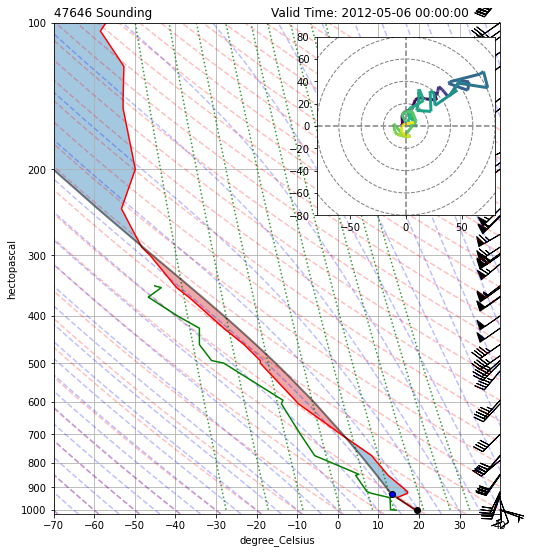

In [16]:
## 作図設定
# 描画範囲
AxTmax = 40     # Celsius
AxTmin = -70
#AxTmin = -30     #for Skew-T
AxPtop = 100    # hPa
AxPBot = 1020
# 描画する断熱線などの指定
dry_tmp = np.arange(203, 533, 10) * units.K
moist_tmp = np.arange(203, 400, 5) * units.K
mix_p = np.arange(1000, 99, -20) * units.hPa
#
## 作図
fig = plt.figure(figsize=fig_size)
# asplectを大きくすると、縦長となる
skew = SkewT(fig, rotation=0, aspect=120)
#skew = SkewT(fig, rotation=45, aspect=60)  #for Skew-T

# 軸の設定
skew.ax.set_xlim(AxTmin, AxTmax)
skew.ax.set_ylim(AxPBot, AxPtop)

# 温度、露点温度、風の描画
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v, y_clip_radius=0.03)

# parcelのプロファイルを追加、パーセルの持ち上げる前の位置、LCLを黒、青で示す
skew.plot(p[i_eptmax:], prof, 'k', linewidth=2, alpha=0.5)
skew.plot(p[i_eptmax], T[i_eptmax], 'ko', markerfacecolor='black')
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='blue')

# CAPE,CINを表す領域をshadeする
skew.shade_cin(p[:], T[:], prof)
skew.shade_cape(p[i_eptmax:], T[i_eptmax:], prof)

# 乾燥断熱曲線などの描画
skew.plot_dry_adiabats(t0=dry_tmp, alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=moist_tmp, alpha=0.25, color='tab:green')
skew.plot_mixing_lines(pressure=mix_p, linestyle='dotted', color='tab:blue')

# タイトル
plt.title('{} Sounding'.format(station), loc='left')
plt.title('Valid Time: {}        '.format(dt), loc='right');

# ホドグラフ描画
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)  # loc = 9 or 1
hd = Hodograph(ax_hod, component_range=80.)
hd.add_grid(increment=20)
hd.plot_colormapped(u, v, h)

plt.show()